In [1]:
cd ..

/Users/yanndubois/SSL-Risk-Decomposition


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#!rm -rf /Users/yanndubois/.cache/torch/hub/YannDubs_SSL-Risk-Decomposition_main

# Collect all results

In [4]:
import torch
import pandas as pd
from utils.plotting import *
from utils.collect_results import *
from utils.causal import *
import numpy as np
import warnings
import logging
import hubconf
from pathlib import Path

 No module named 'clip'


In [5]:
is_read_files=True
DATA = "imagenet"
subset = None
pred = 'torch_linear_delta_hypopt'
threshold_kwargs=dict()    

metadata_df = hubconf.metadata_df(is_multiindex=False)

if is_read_files:
    results = load_all_results(pattern=f"**/data_{DATA}/**/pred_{pred}/seed_*/results_all.csv",
                               skip_ifneq=dict(data=DATA.lower()),
                               skip_ifin=dict(ssl=["swav_rn50w5","selav2_rn50_ep400_2x160_4x96"]),
                              )
    check_missing(results, metadata_df)
    results = format_approx_results(results, metadata_df, f_replace_arch=f_replace_arch, subset=subset)
    results = make_risk_decomposition(results, traverse_path=["down","right","down"], is_print=True, subset=subset)
    results, metadata_df = clean_results(results, metadata_df, predictor=pred)
    validate_results(results, metadata_df, threshold_delta=5, **threshold_kwargs)

    results.to_csv(f"notebooks/saved/results_{DATA}_{pred}.csv")
    
    # filter out values that are suspiciously bad
    to_del = []
    to_keep = [i for i in results.index.get_level_values("enc") if i not in to_del]
    results = results.loc[to_keep]
else:
    results=pd.read_csv(f"notebooks/saved/results_{DATA}_{pred}.csv",index_col=0)
    
    
metadata_df = metadata_df.loc[to_keep]
df = pd.concat([results,metadata_df], axis=1)
df = df.replace(dict(ssl_mode={"hierarchical contrastive": "hierarchical"}))
df["n_augmentations"] = df["augmentations"].apply(lambda s: len(s))

# coarsens many different parameters for cleaner plots
#df = preprocess_features(df, round_dict={}, pow_dict={})

melted = melt(df)

Found 153 result files to load.


Found missing supervised models for:


,pred,seed,arch
0,torch_linear_delta_hypopt,123,vith14 cls
1,torch_linear_delta_hypopt,123,vits8 cls


[usability] = [train_train] - [sup_train_train]
[probe_gen] = [train-cmplmnt-ntest_train-sbst-ntest] - [train_train]
[enc_gen] = [train_test] - [train-cmplmnt-ntest_train-sbst-ntest]


Found negative values:


,approx,usability,probe_gen,enc_gen,agg_risk
enc,,,,,
dino_vitb16_extracts,1.548,-0.737,18.231,4.530,23.572
dissl_resnet50_d4096_e100_m2,0.845,-0.354,32.503,-0.148,32.846
dissl_resnet50_d8192_e100_m2,0.845,-0.189,31.620,1.302,33.578
dissl_resnet50_d8192_e400_m6,0.845,-0.381,24.064,3.816,28.344
dissl_resnet50_d8192_e800_m8,0.845,-0.382,23.417,4.124,28.004
mugs_vitb16_ep400_extractb,7.634,-5.555,15.023,3.266,20.368
pirl_rn50w2_headmlp,0.743,-0.091,25.429,3.422,29.502
simclr_resnet50_d8192_e100_m2,0.845,-0.381,29.967,3.488,33.920
simclr_rn50w2,0.743,-0.271,22.044,3.544,26.060


The following results seem suspicously bad:


,agg_risk
enc,
beit_vitb16_pt22k,57.194


The following models have very different original and evalauted performance:


enc
deepcluster_rn50_bs512_ep200_mmselfsup   -17.566000
dissl_resnet50_dnone_e100_m2               5.037999
jigsaw_rn50                               10.766001
jigsaw_rn50_in22k                         17.584002
msn_vitl16_ep600                           6.359999
rotnet_rn50_in1k                           7.164002
rotnet_rn50_in22k                          7.314002
simclr_rn50_bs256_ep200_mmselfsup          6.275999
speccl_resnet50_bs384_ep100                5.306000
dtype: float64

The following results have some nan:


,approx,usability,probe_gen,enc_gen,agg_risk
enc,,,,,
dino_vits8_last,NaN,NaN,4.449,3.818,21.794
mae_vith14,NaN,NaN,14.514,3.466,24.008


In [6]:
#non_core_params = ['date_published','top1acc_in1k_official','projection_nparameters']
core_params = ['objective','version','architecture','patch_size','z_dim','z_layer',
               "epochs","batch_size", "optimizer", "learning_rate", "weight_decay", "scheduler",
               "pretraining_data",'img_size','year',"nviews",'finetuning_data','projection_arch']
minimal_params = ['objective','version','architecture','patch_size','z_dim','z_layer',"pretraining_data",'finetuning_data']
df_core = df.set_index(core_params)[results.columns]
df_minimal = df.set_index(minimal_params)[results.columns]
melted_onlyComp = melt(df, components=COMPONENTS_ONLY)


## Overview



### Risk components
Now let us look at the risk decomposition aggregated

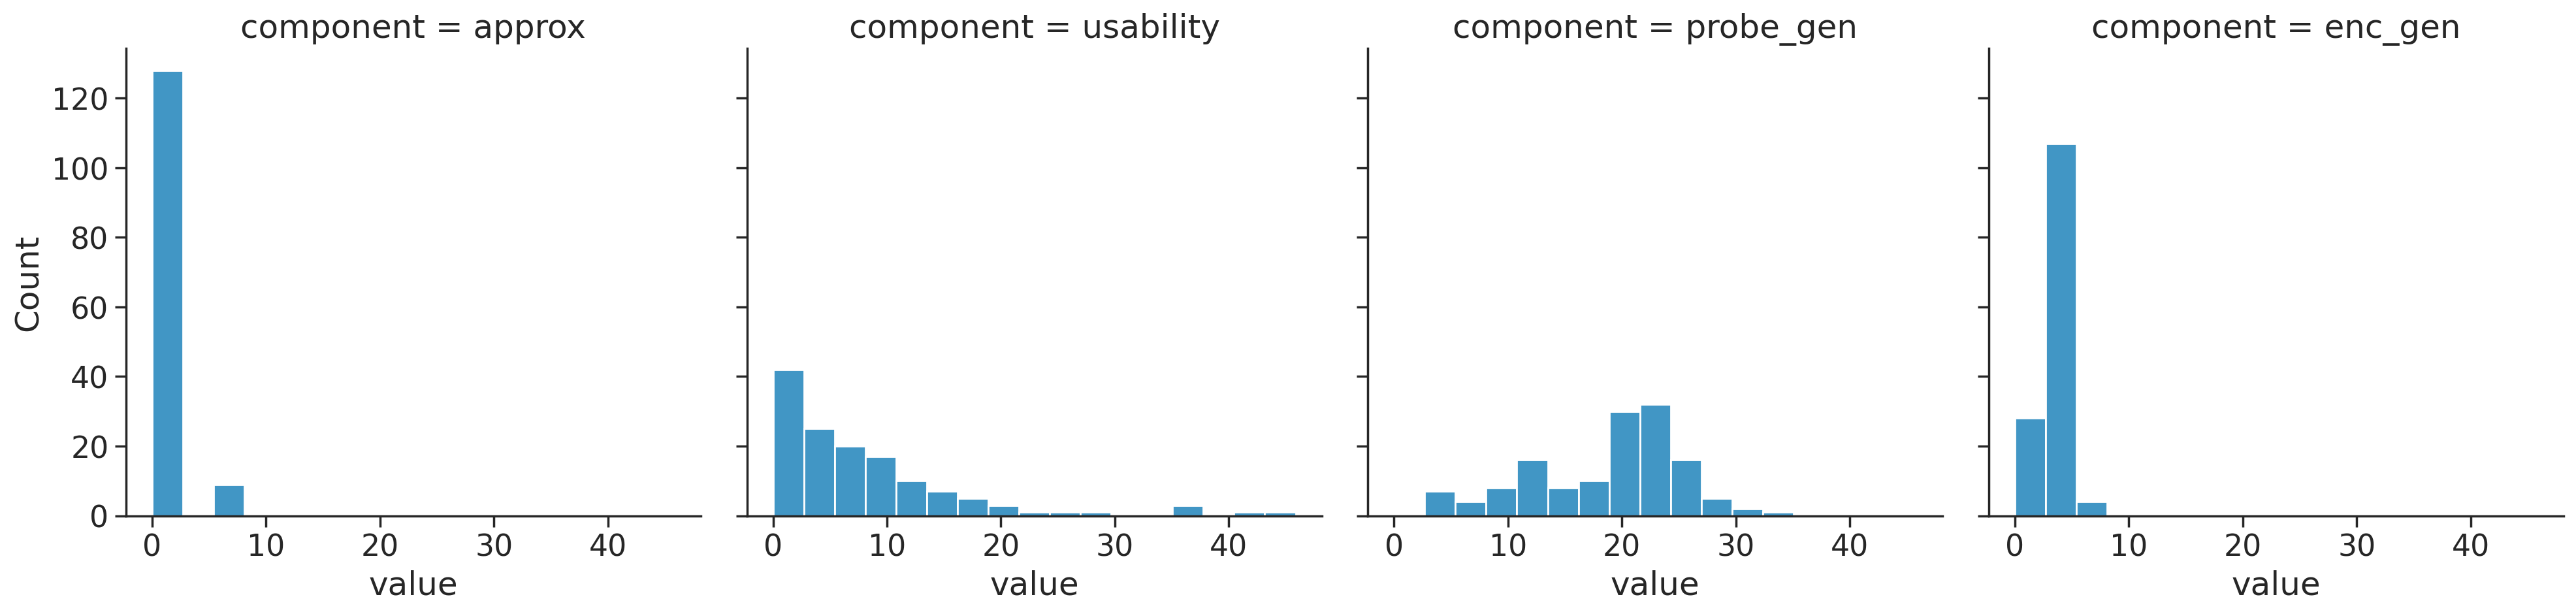

In [7]:
with plot_config():
    sns.displot(melted_onlyComp, x="value", col="component")

### Features

In [8]:
X,y=prepare_sklearn(df)

In [9]:
# from pandas_profiling import ProfileReport



# path = Path("notebooks")/"profile.pp"
# if path.exists():
#     profile = ProfileReport()
#     profile.load(path)
# else:
#     profile = ProfileReport(X)
#     profile.to_html()
#     profile.dump(path)
# profile

## Trends
Let's see how each components changed over time. We will aggregate per year as a rough estimate.

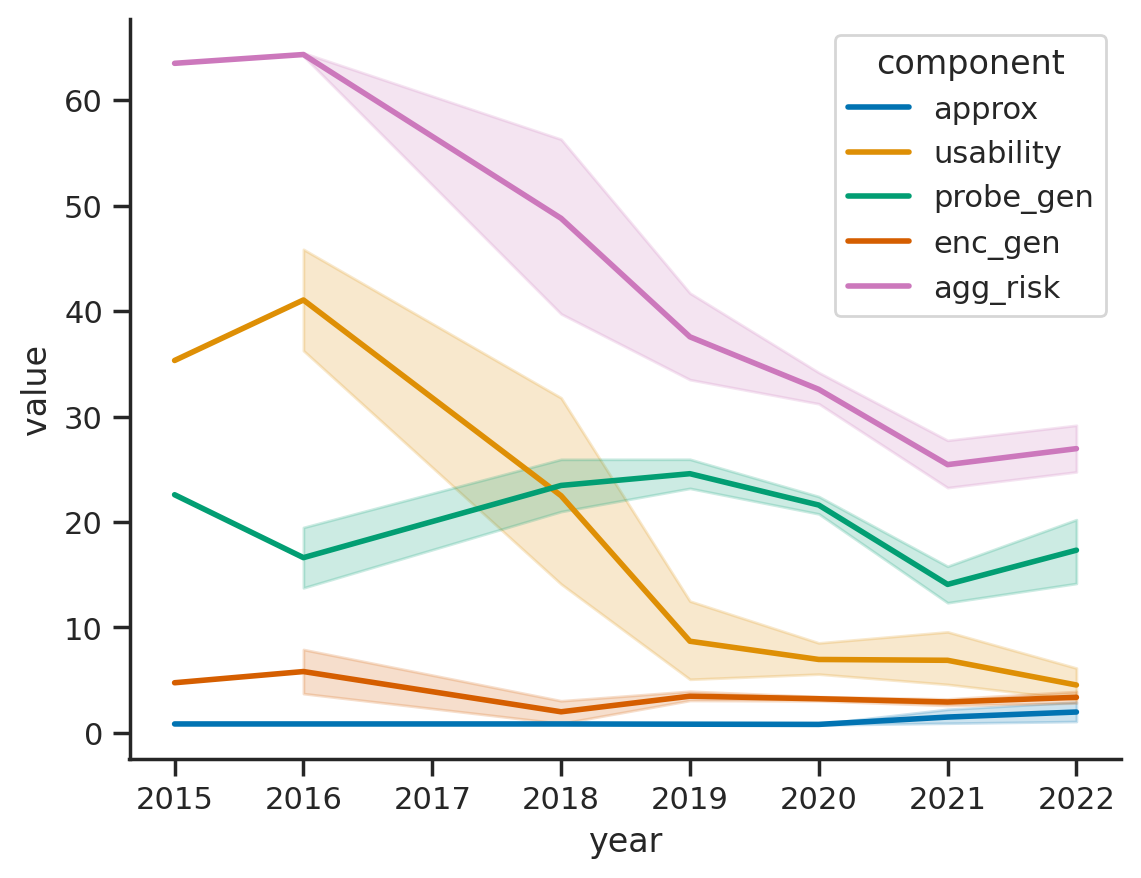

In [10]:
with plot_config(font_scale=1):
    sns.lineplot(data=melted, x="year", y="value", hue="component")

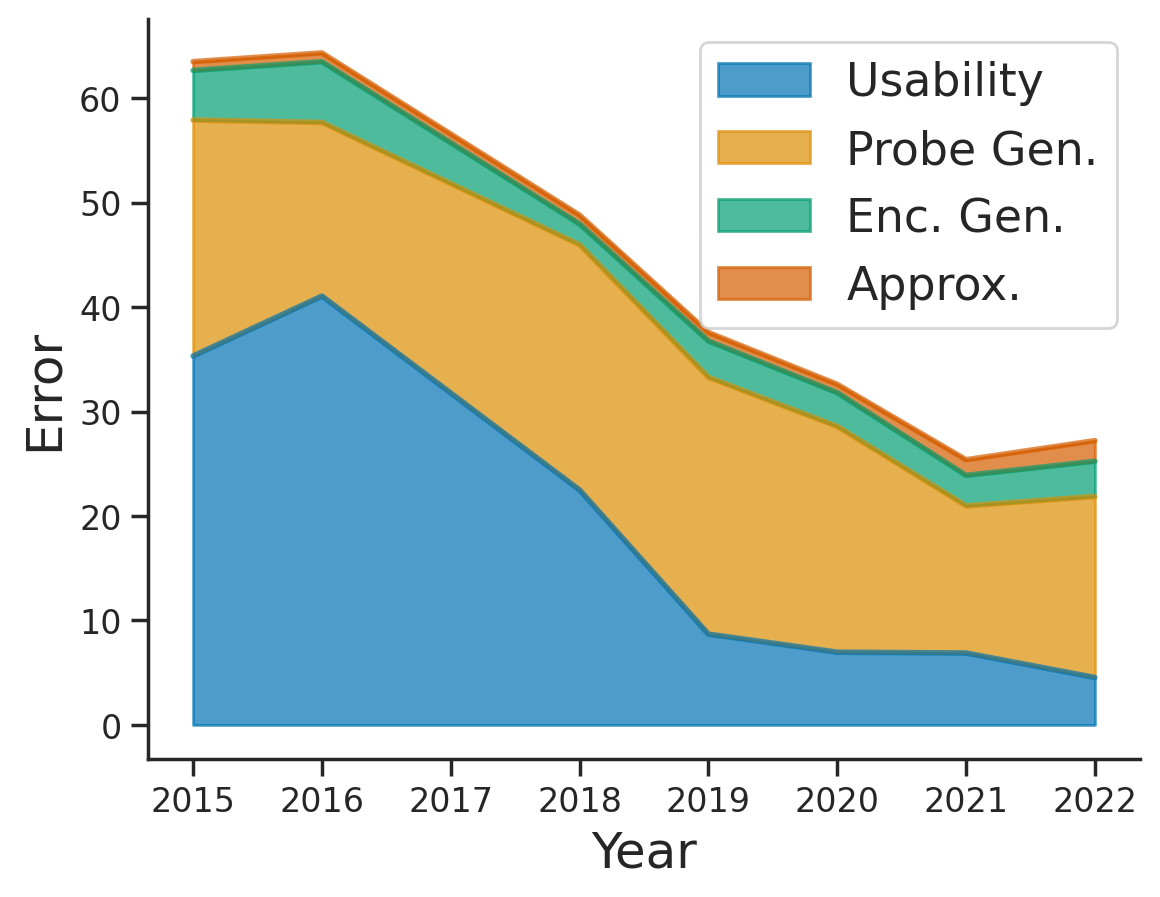

In [11]:
with plot_config(rc={'lines.linewidth': 2, 'font.family': 'sans-serif', 
                    "ytick.labelsize": 12, "xtick.labelsize": 12}
                ):
    curr_df = df.copy()[COMPONENTS_ONLY_IMP + ["year"]]
    curr_df.columns = [PRETTY_RENAMER[c] for c in curr_df.columns]
    ax = curr_df.groupby("Year").mean().plot.area(alpha=0.7)
    ax.set_ylabel("Error")

In [12]:
import ipdb
def test(data, **kwargs):
    data[COMPONENTS_ONLY+["year"]].groupby("year").mean().plot.area(ax=plt.gca())

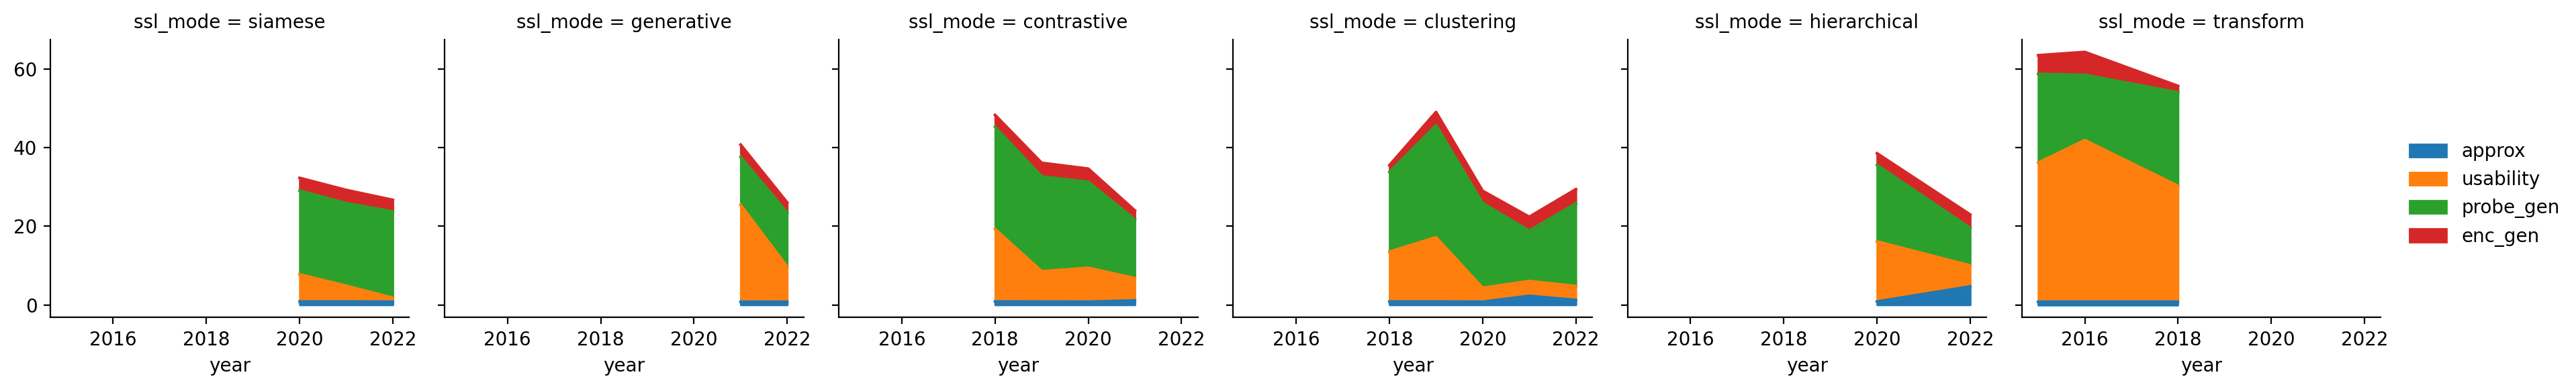

In [13]:
import ipdb
def test(data, **kwargs):
    data[COMPONENTS_ONLY+["year"]].groupby("year").mean().plot.area(ax=plt.gca())
    
curr_df = df.copy()[COMPONENTS_ONLY + ["year","ssl_mode"]]
g = sns.FacetGrid(curr_df, col = 'ssl_mode')
g = (g.map_dataframe(test).add_legend())

In [14]:
df["ssl_mode"].value_counts()

contrastive     51
clustering      47
siamese         19
generative       9
hierarchical     8
transform        5
Name: ssl_mode, dtype: Int64

We see that most of the gains over time have been hapening in usability, while the oters haven't changed much. We are now at the point were usability ~= probe gen ~= approx error. We also see that the generalization error is really not a problem at this scale. Note that it might be surprising to see that the probe doesn't generalize so well despite having hundred of thousands of training points and being only linear. 

Now let's consider models that have the same objectives but have changed over time (hparam tuning) as different version. 

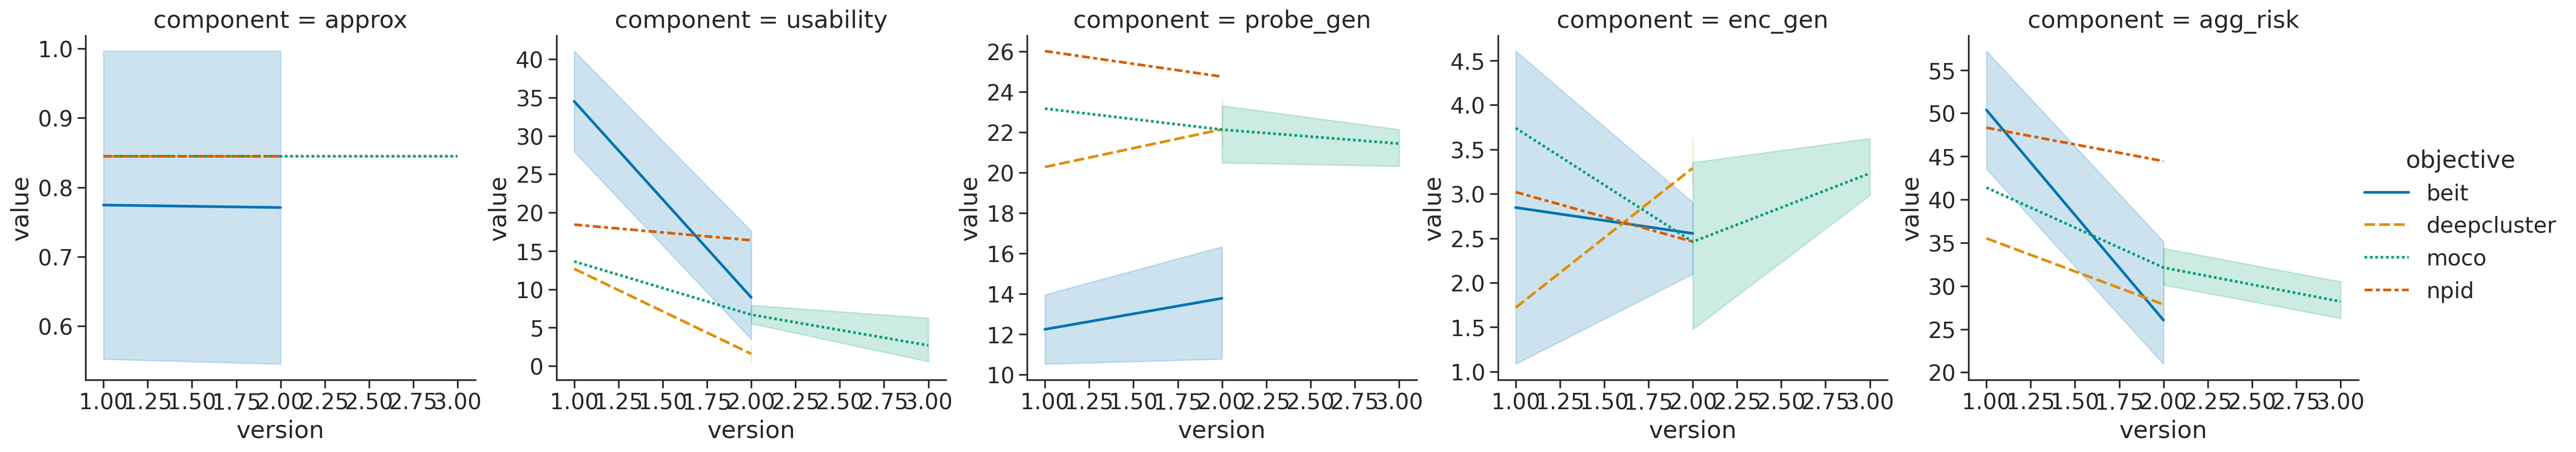

In [15]:
with plot_config():
    df_version = melt(get_only_vary(df, ["version"], ["objective","version","architecture"]))

    sns.relplot(data=df_version, 
                x="version", 
                y="value", 
                hue="objective",
                style="objective",
               col="component",
               kind="line",
                facet_kws={'sharey': False}, 
                #err_style="bars"
               )

We see again that in the three cases usability has been the main driver of progress.

It seems that the ssl mode mostly has an impact on the usability component with transform and generative being very bad. 

## Naive plots
The following are naive plots where we plot everything without thinking about confounders. As a result they are likely meaningless for interpretaition but should rather be used as ways to understand our data.


### Effect of type of method

Now let's consider the effect of the type of method

**Hypothesis** ISSL showed that contrastive, distillation and clustering all optimize nearly the right objective and can be made correct with minor differences, so we hypothesize that usability for them must be good.

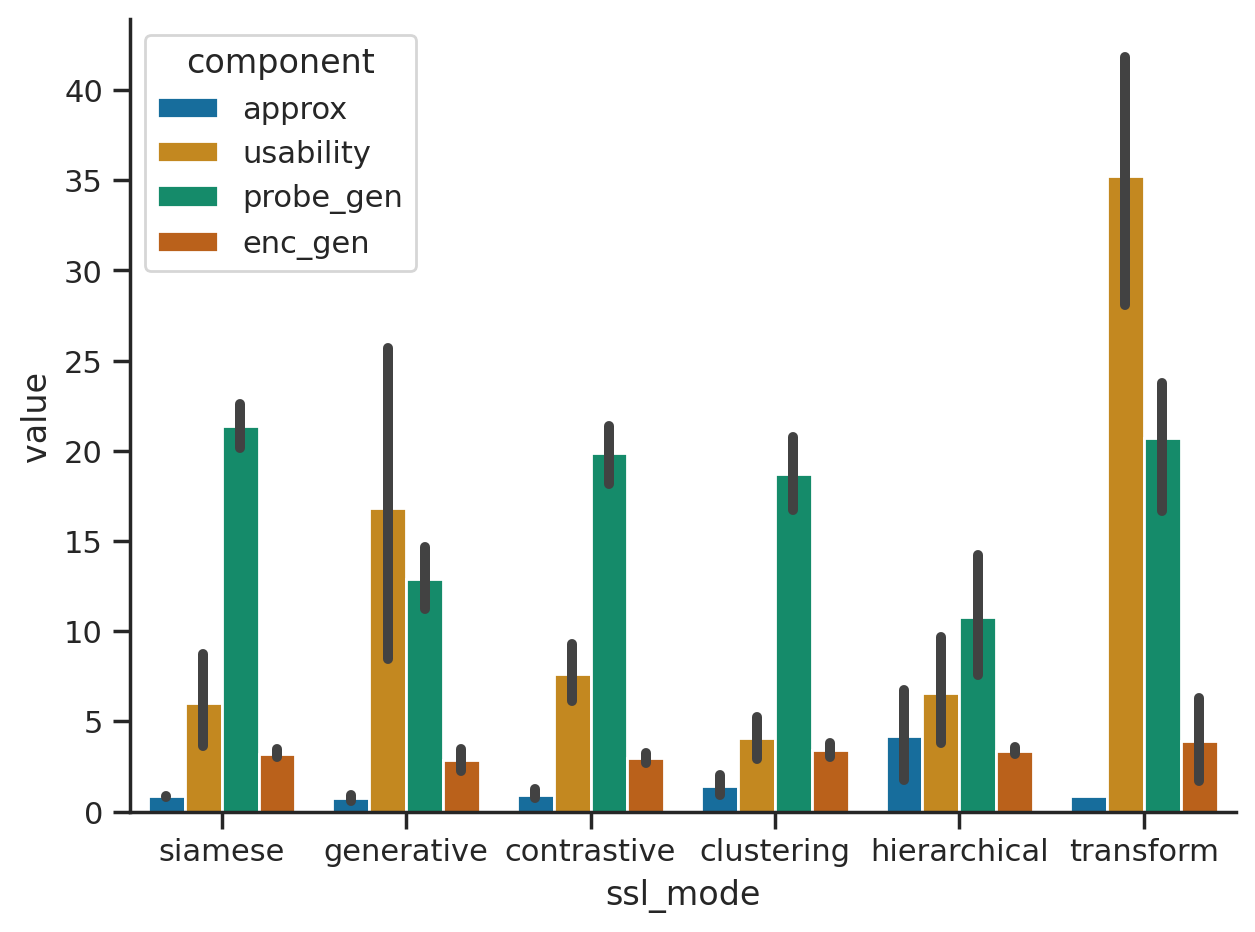

In [16]:
with plot_config(font_scale=1):
    sns.barplot(data=melted_onlyComp, x="ssl_mode", y="value", hue="component")
    plt.tight_layout()

### Effect of epochs

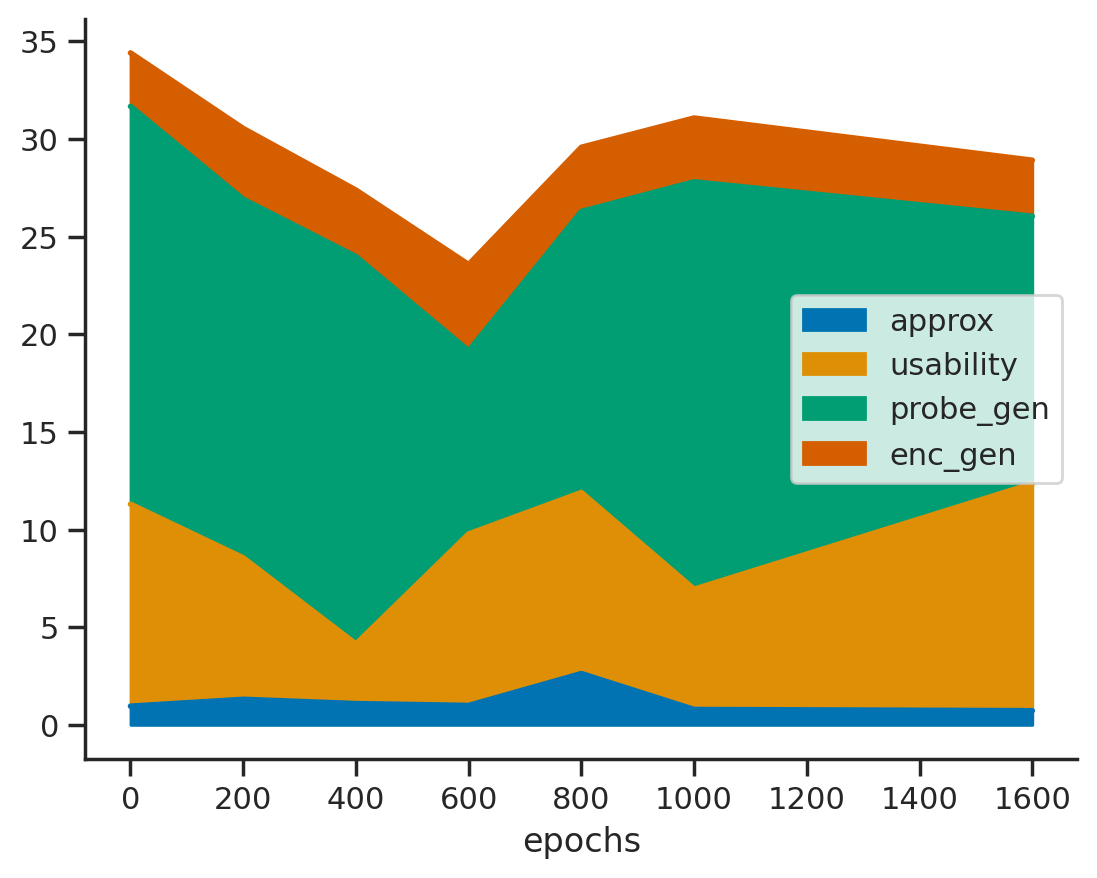

In [17]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["epochs"]])
    curr_df.epochs = curr_df.epochs // 200 * 200 # coarse grains
    curr_df.groupby("epochs").mean().plot.area()

Doesn't show much

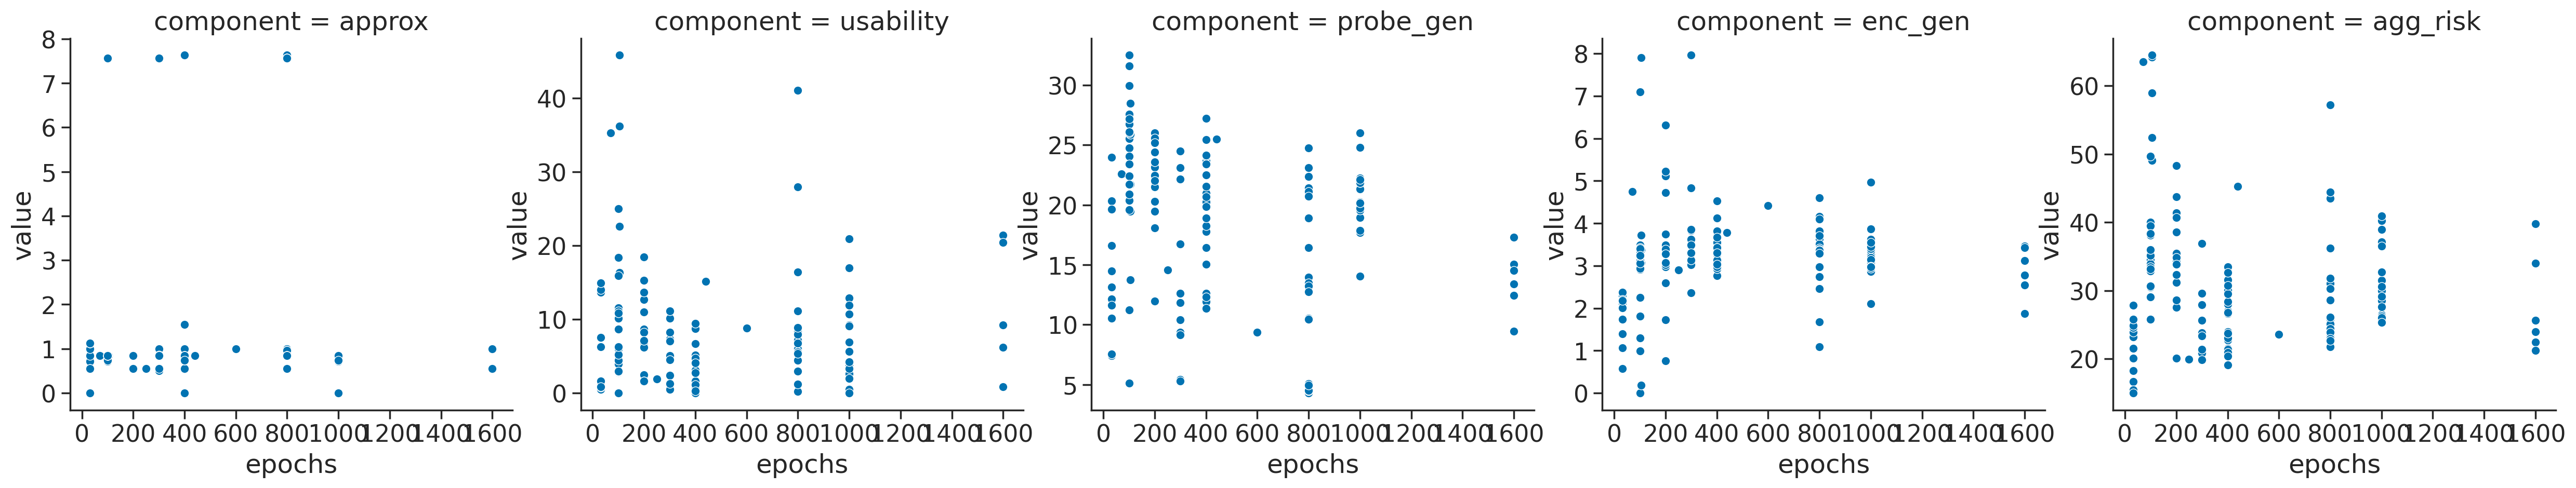

In [18]:
with plot_config():
    sns.relplot(data=melted, x="epochs", y="value", col="component", facet_kws={'sharey': False})

### Effect of batch size

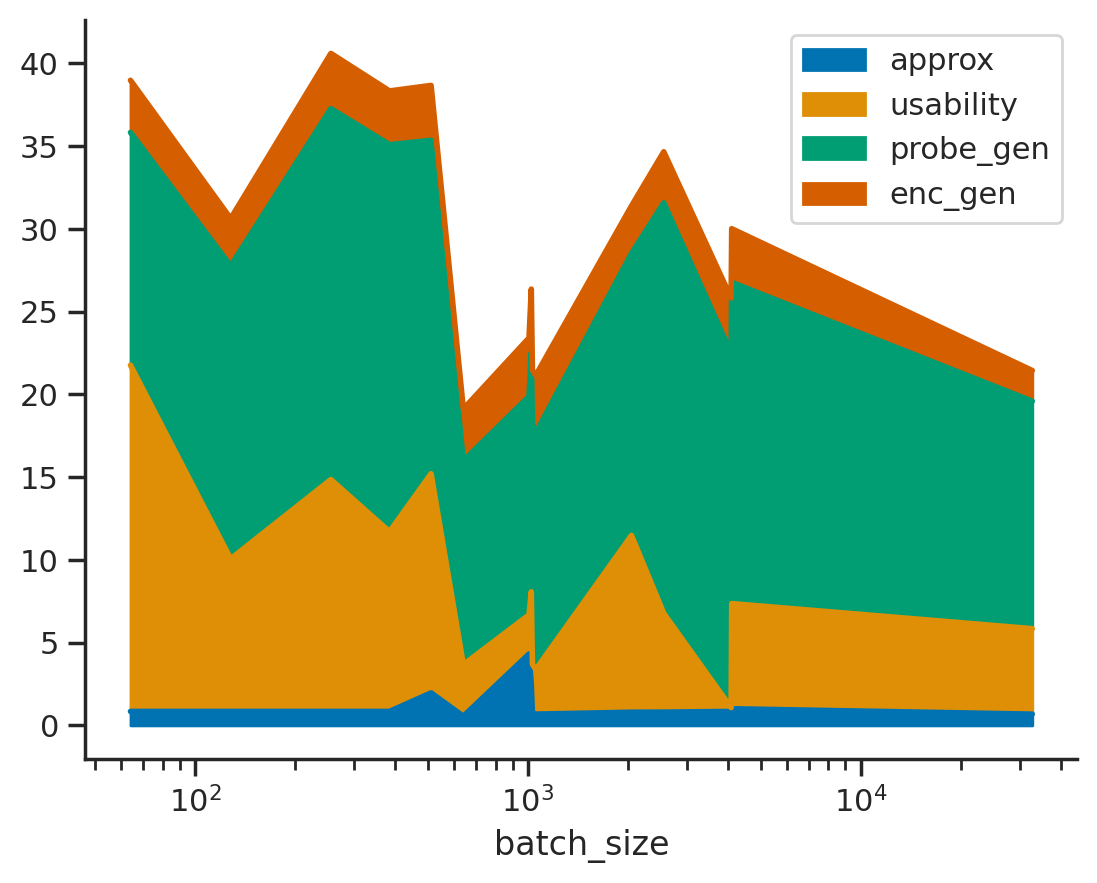

In [19]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["batch_size"]])
    curr_df.groupby("batch_size").mean().plot.area(logx=True)

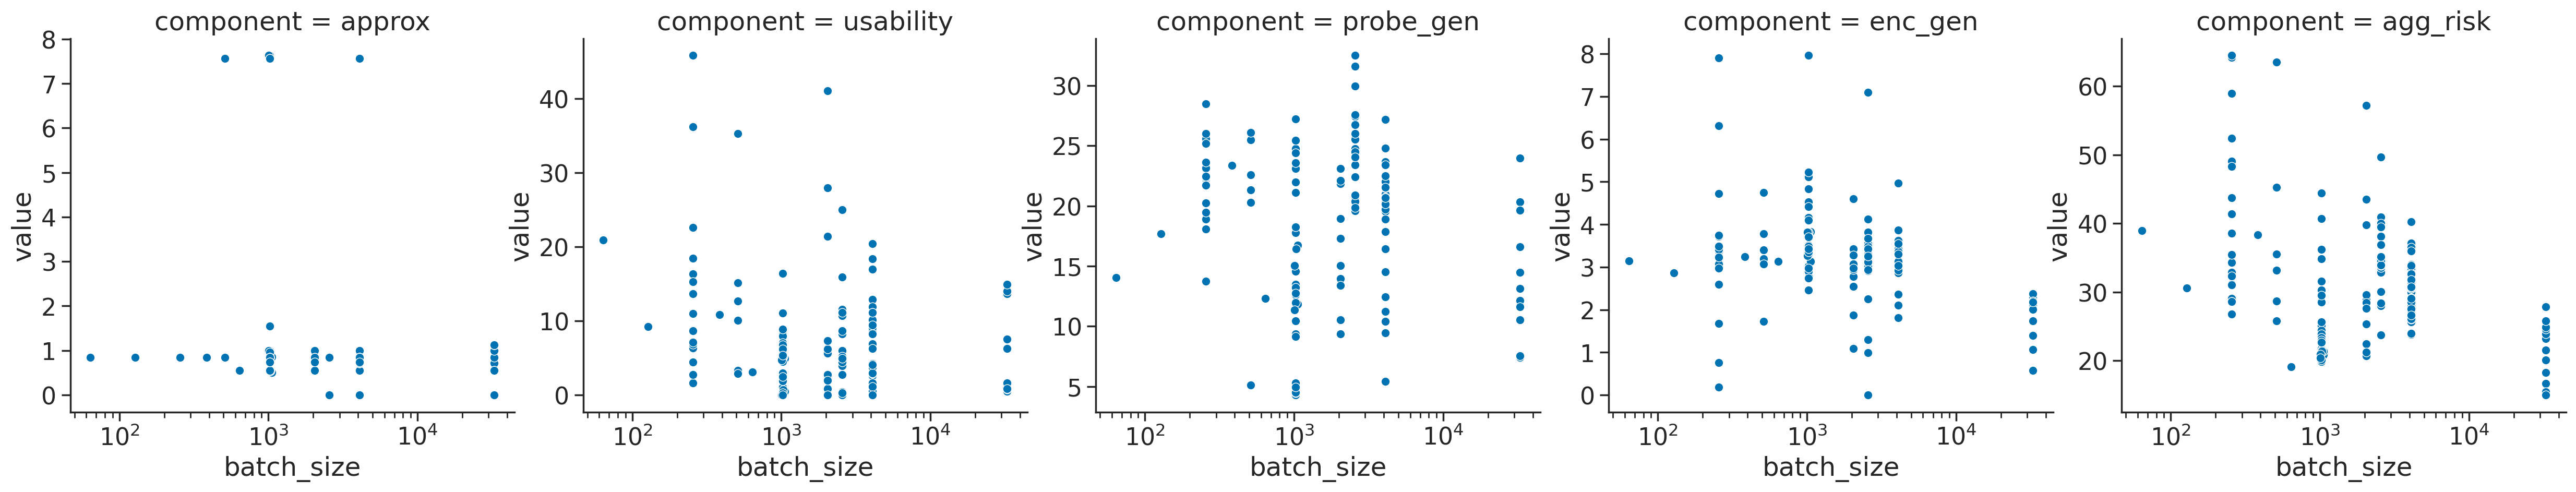

In [20]:
with plot_config():
    g=sns.relplot(data=melted, x="batch_size", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

### Effect of multicrops

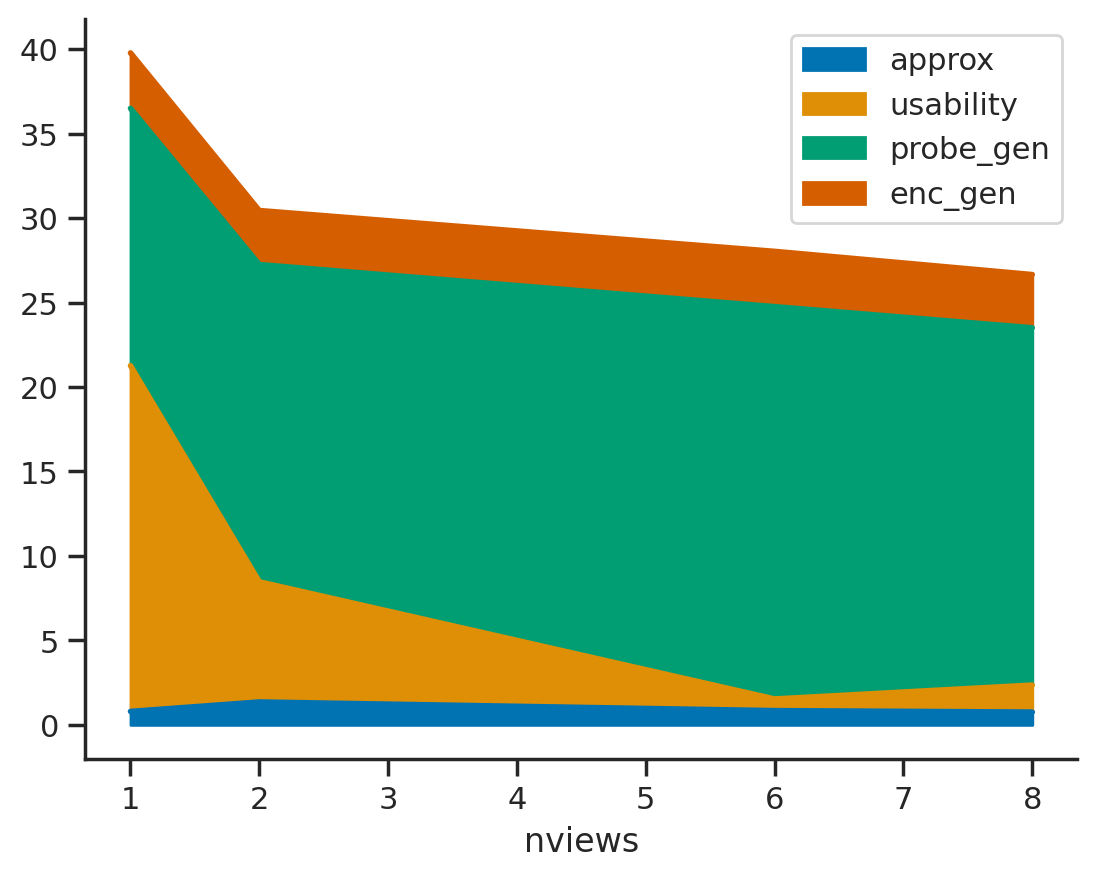

In [21]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["nviews"]])
    curr_df.groupby("nviews").mean().plot.area()

We see that nviews seems to have a huge effect on usability but detrimental effect on probing generalization. That being said there is probably a big confounder as few models (and usually more recent) use multicrops.

### Effect of dimensionality

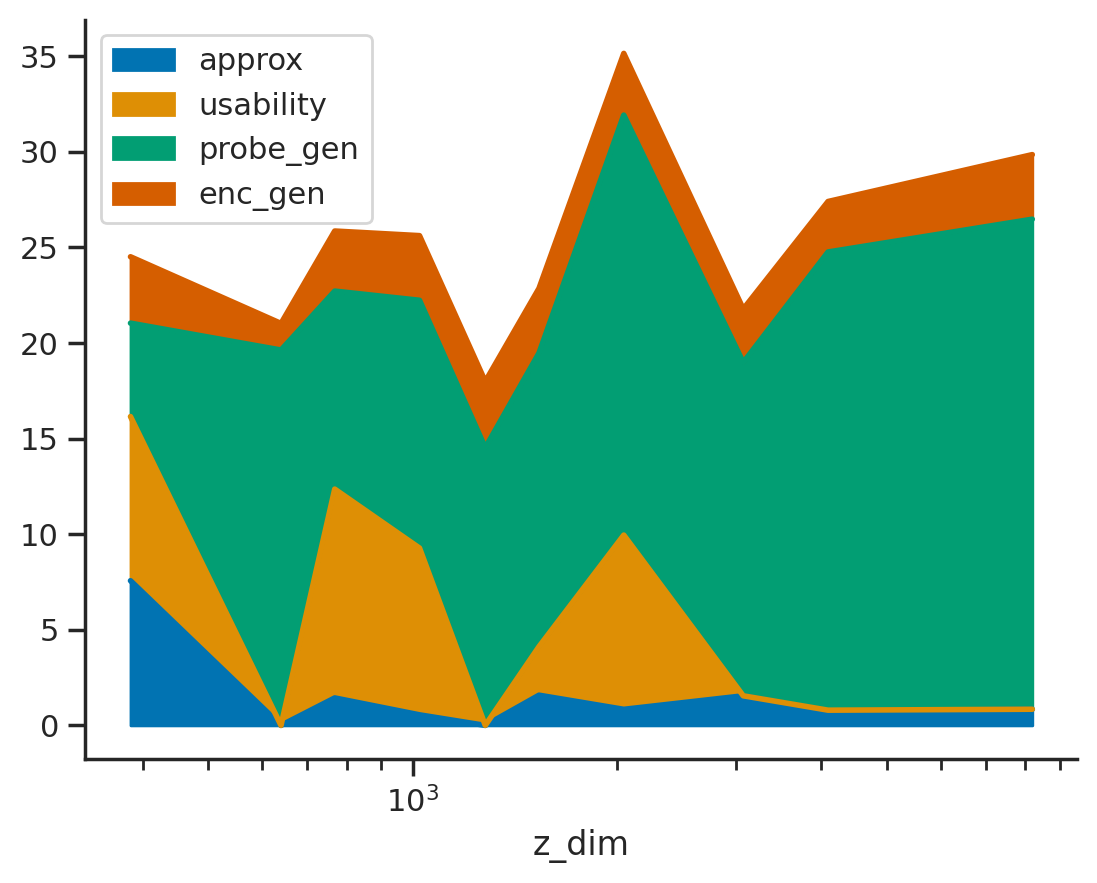

In [26]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["z_dim"]])
    curr_df.groupby("z_dim").mean().plot.area(logx=True)

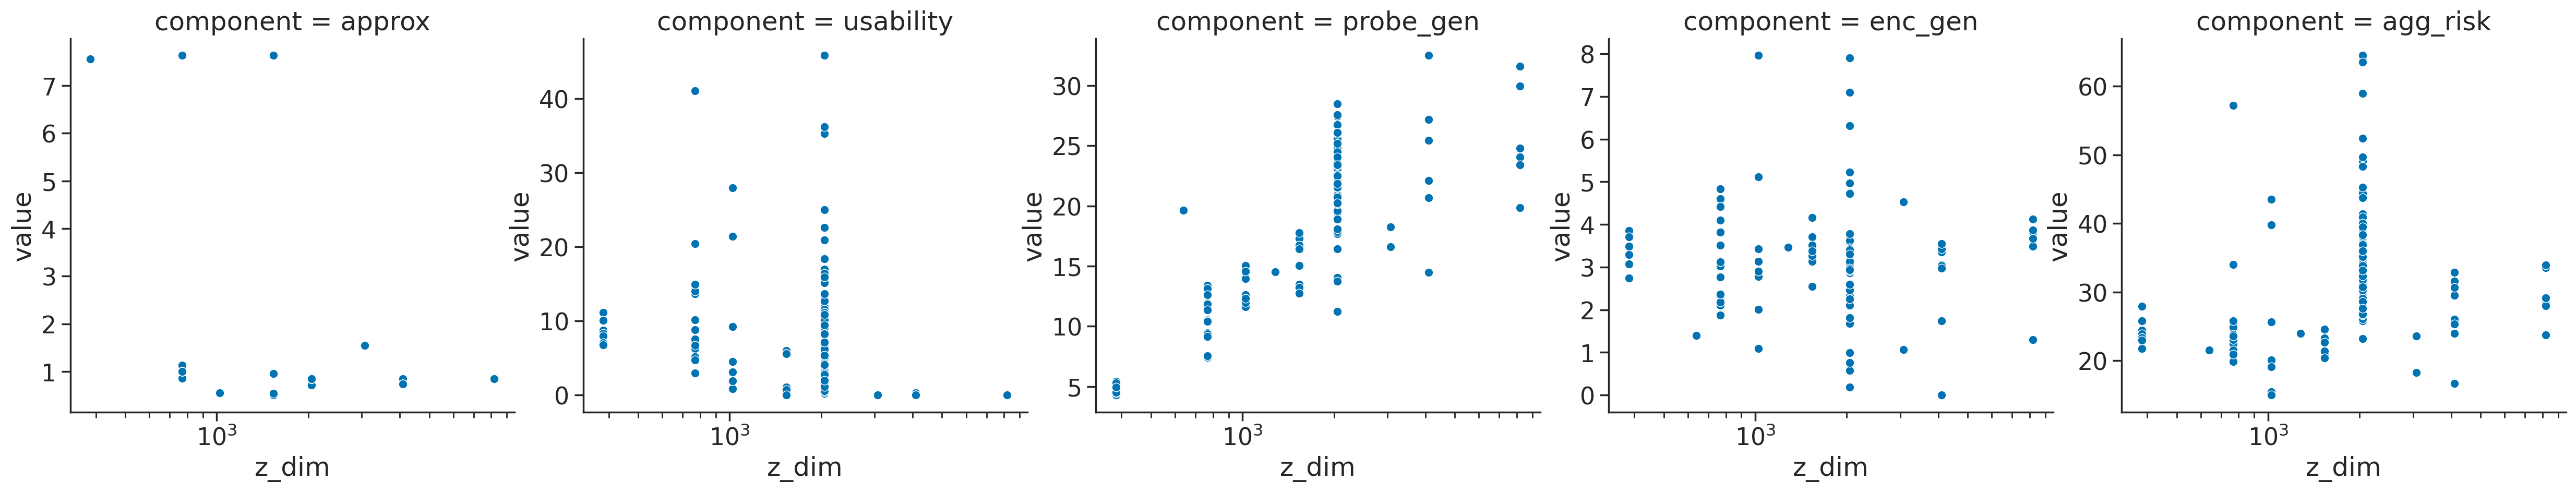

In [27]:
with plot_config():
    g=sns.relplot(data=melted, x="z_dim", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

### Effect of Weight decay

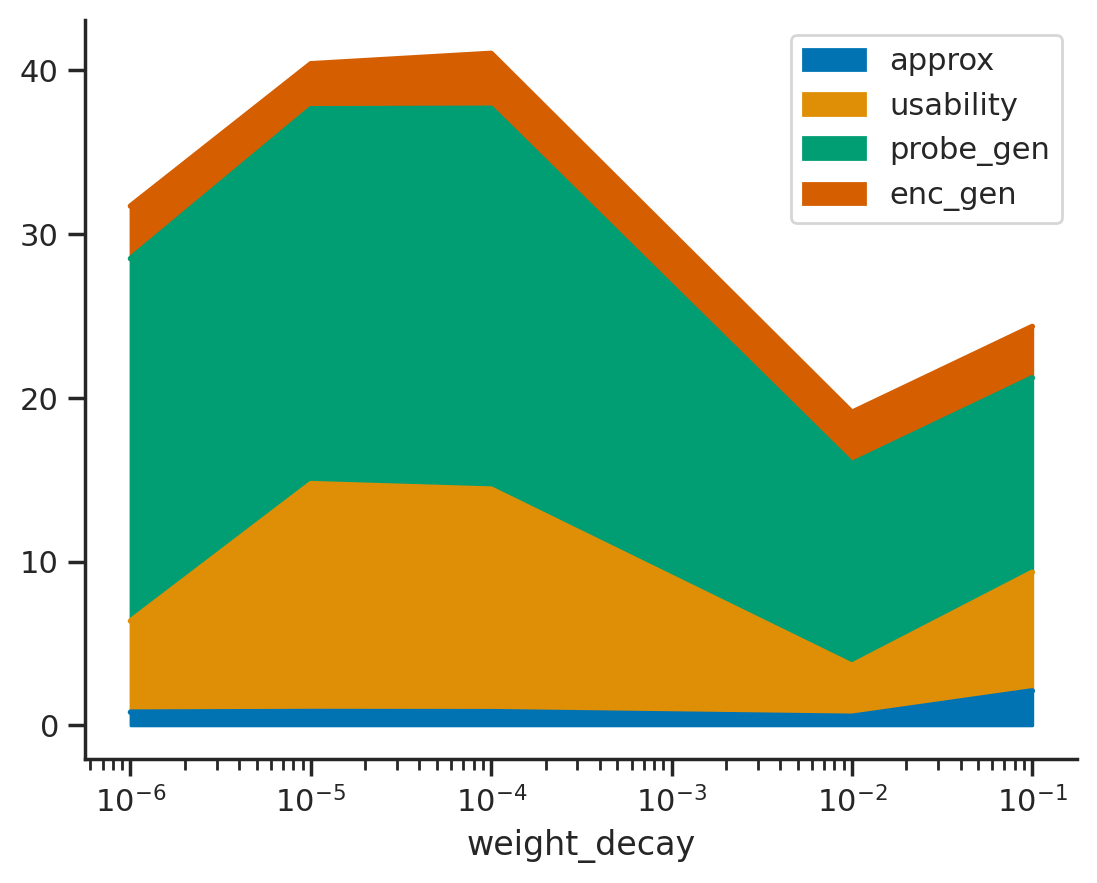

In [31]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["weight_decay"]])
    curr_df.weight_decay = 10**np.log10(curr_df.weight_decay).round()
    curr_df.groupby("weight_decay").mean().plot.area(logx=True)

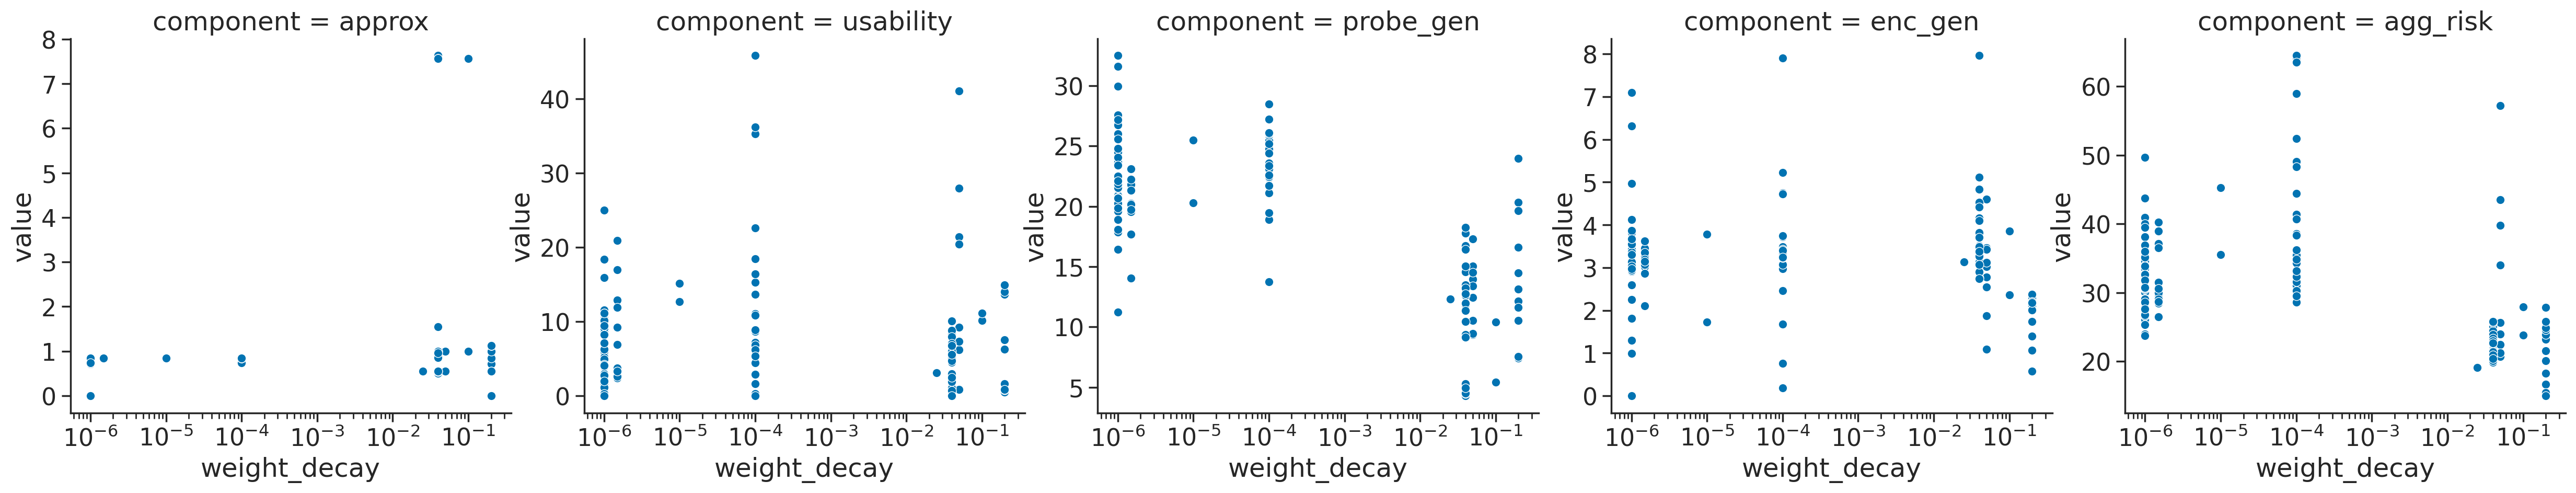

In [32]:
with plot_config():
    g=sns.relplot(data=melted, x="weight_decay", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

### Effect of optimizer

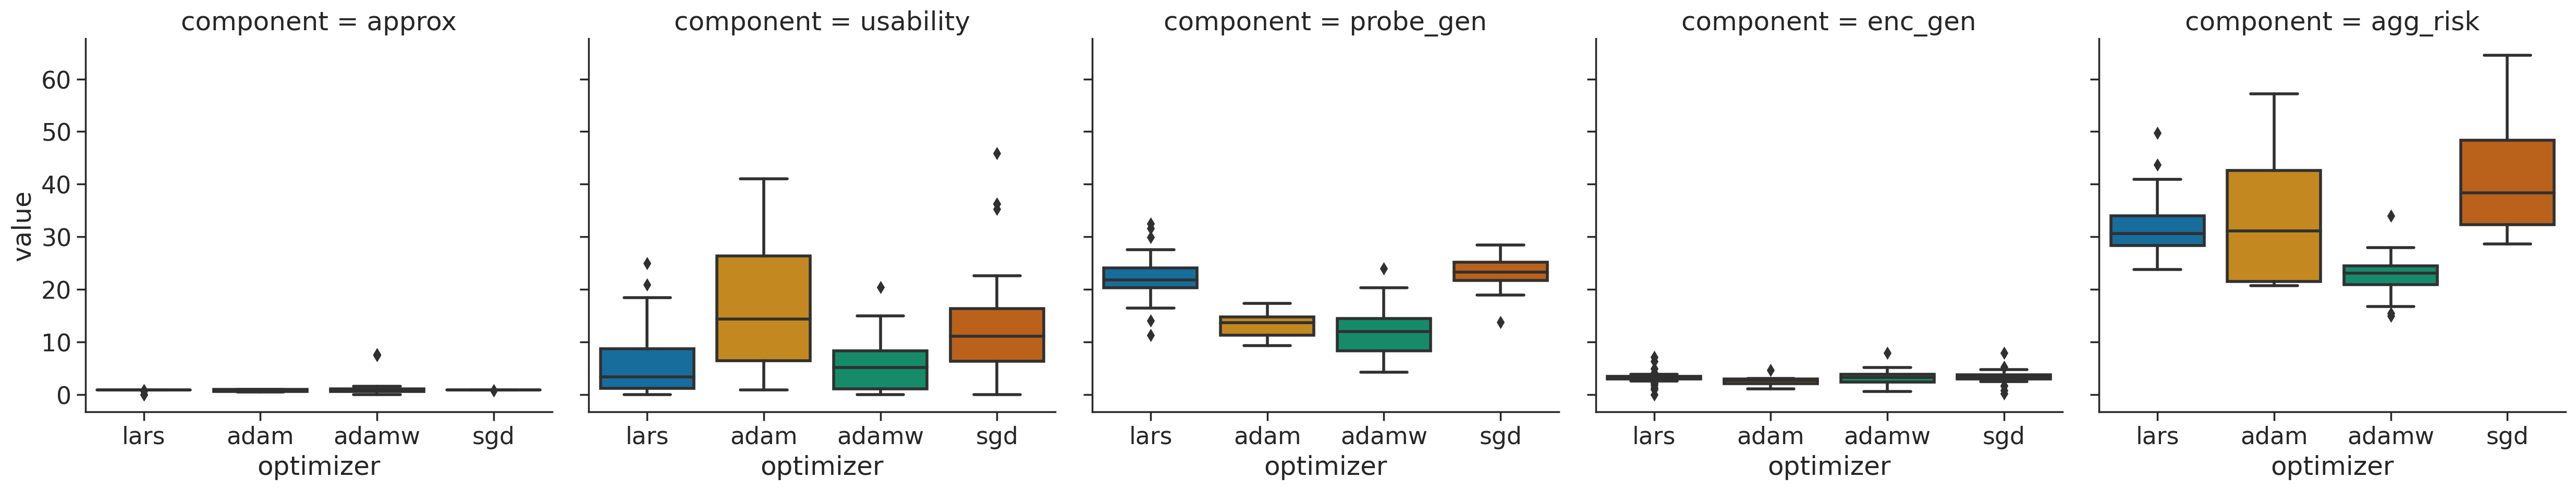

In [33]:
with plot_config():
    g=sns.catplot(data=melted, x="optimizer", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

### Effect of architecture

#### N parameters

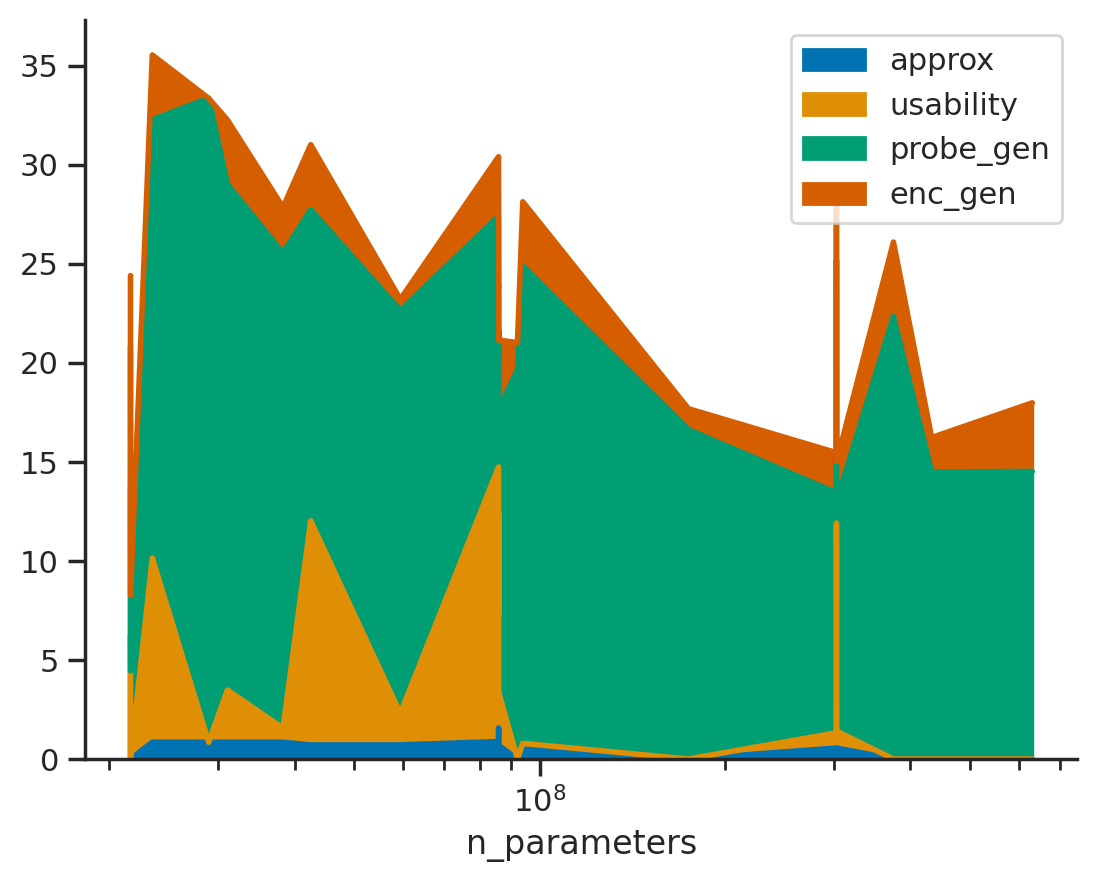

In [28]:
with plot_config(font_scale=1):
    curr_df = copy.deepcopy(df[COMPONENTS_ONLY + ["n_parameters"]])
    curr_df.groupby("n_parameters").mean().plot.area(logx=True)

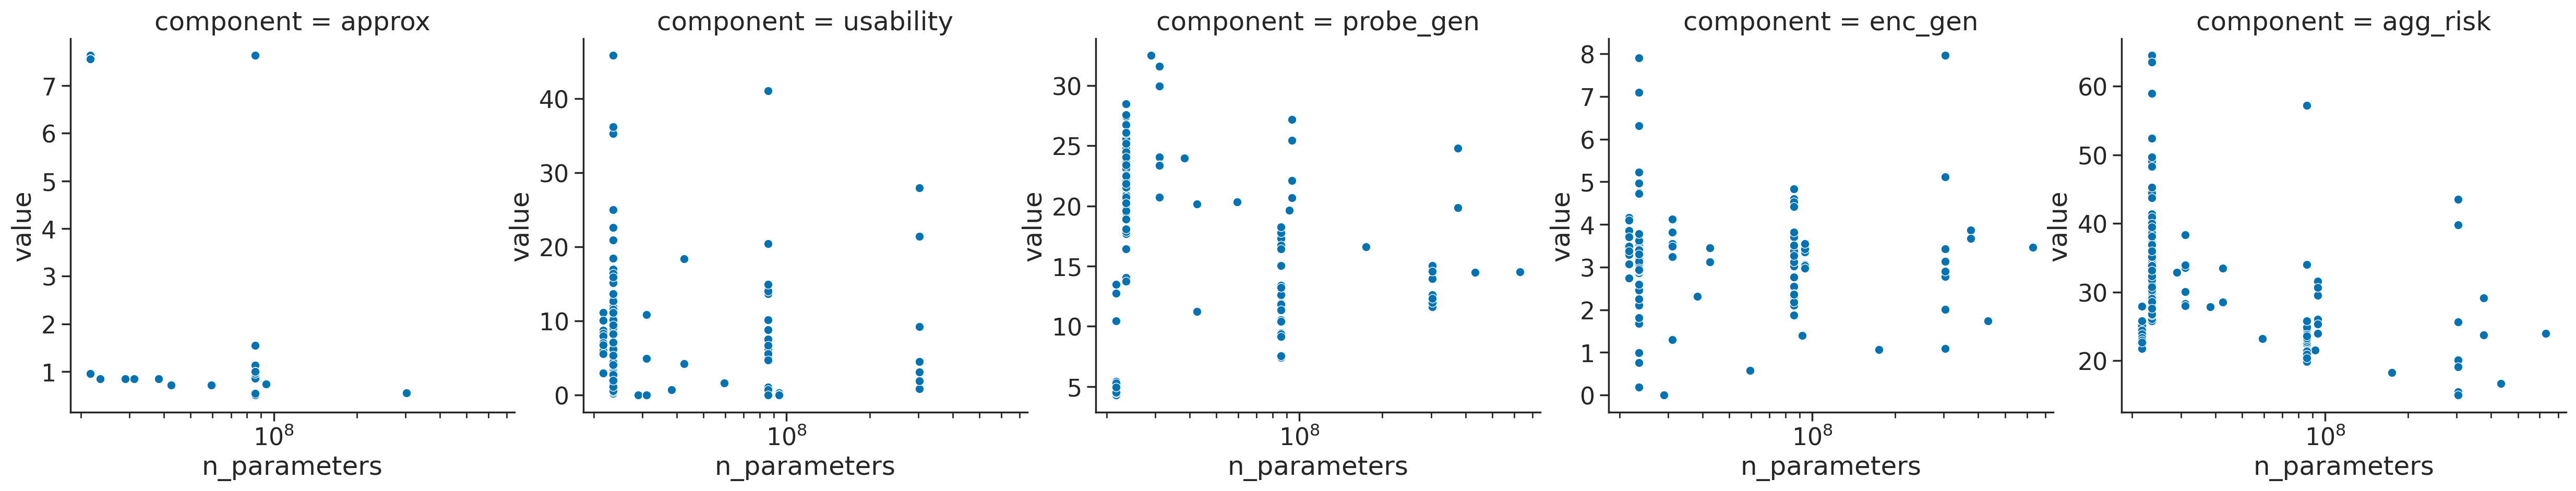

In [29]:
with plot_config():
    g=sns.relplot(data=melted, x="n_parameters", y="value", col="component", facet_kws={'sharey': False})
    g.set(xscale="log")

#### ViT vs ResNet

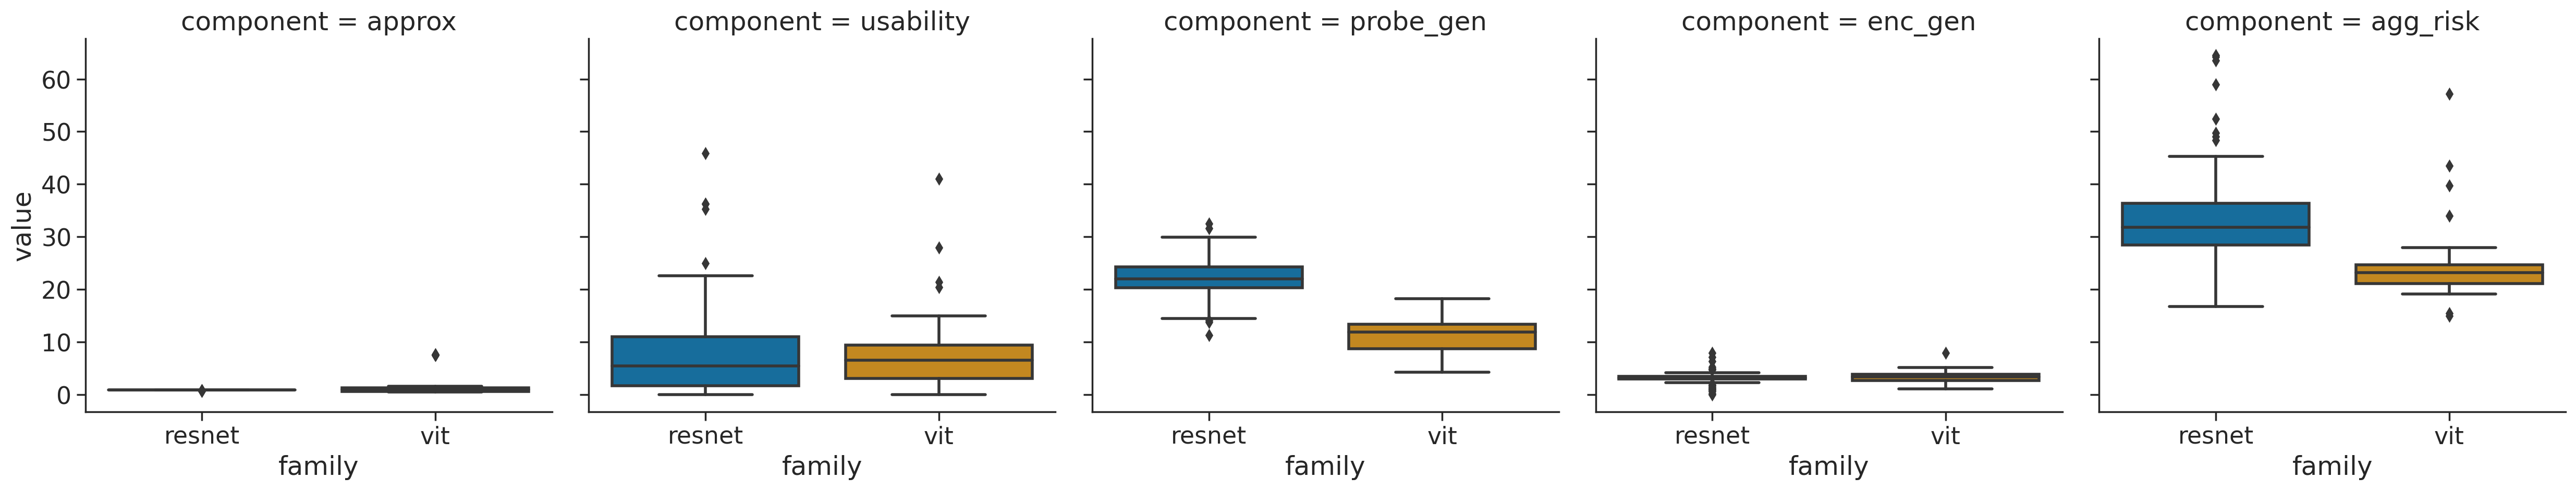

In [30]:
with plot_config():
    g=sns.catplot(data=melted, x="family", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

Appproximation gap seems slightly better.

#### Effect of patch size

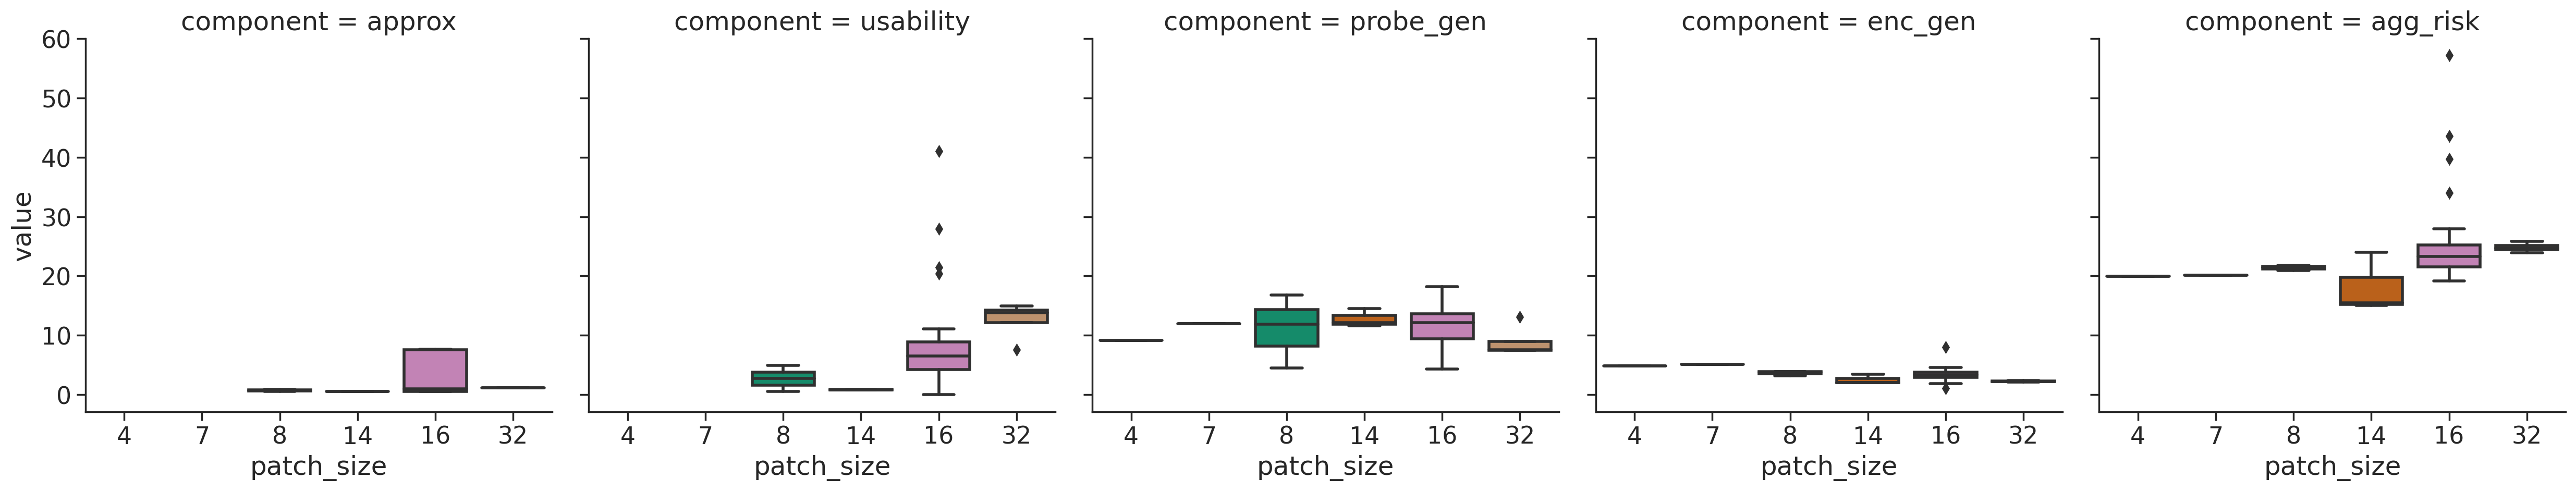

In [31]:
with plot_config():
    g=sns.catplot(data=melted[melted.family=="vit"], 
              x="patch_size", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

Larger patch size is worst approx

### Effect of projection 

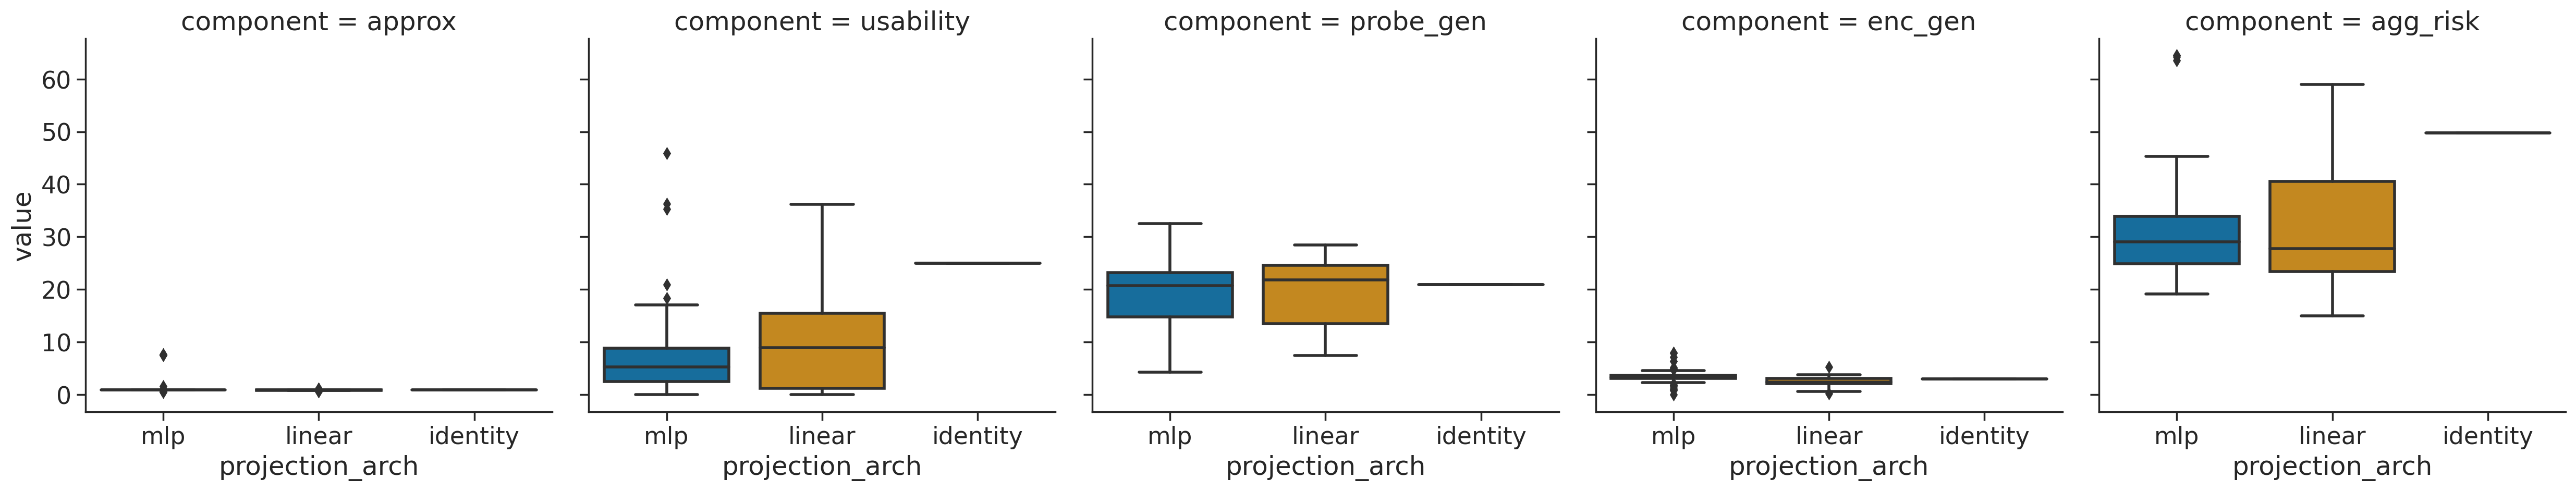

In [32]:
with plot_config():
    g=sns.catplot(data=melted, x="projection_arch", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")

### Effect of pretraining data

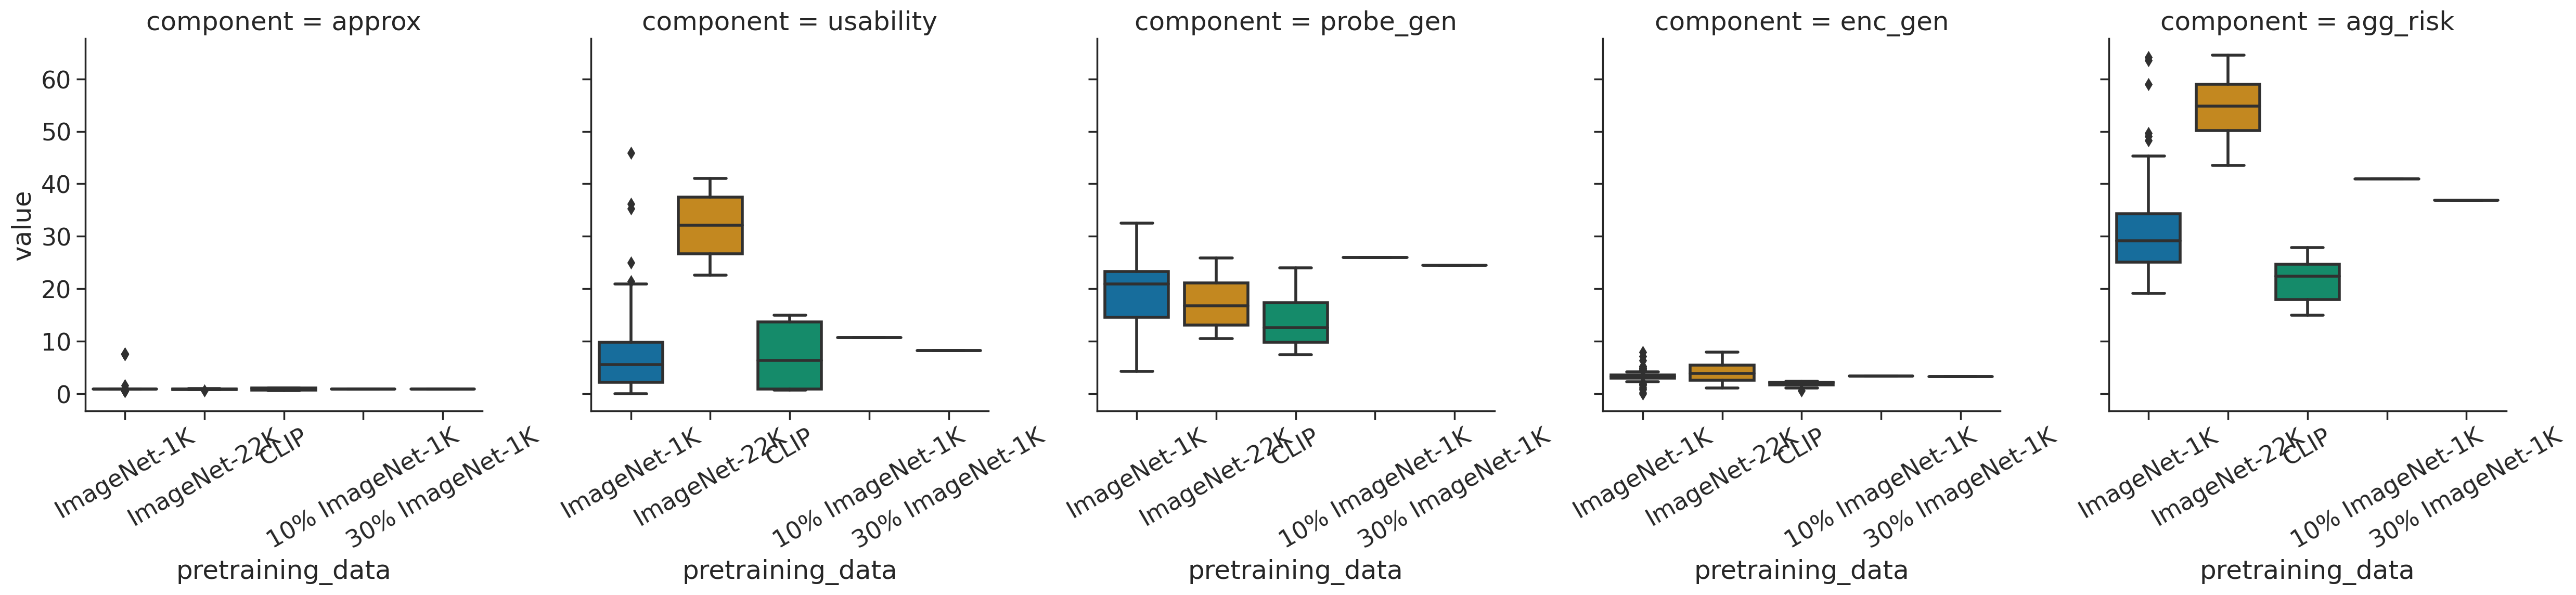

In [33]:
with plot_config():
    g=sns.catplot(data=melted, x="pretraining_data", y="value", col="component", facet_kws={'sharey': False}, kind="box")
    g.set_xticklabels(rotation=30)

### Effect of finetuning

In [34]:
curr_df = df.copy()
curr_df["is_finetuned"] = curr_df.finetuning_data.isna()

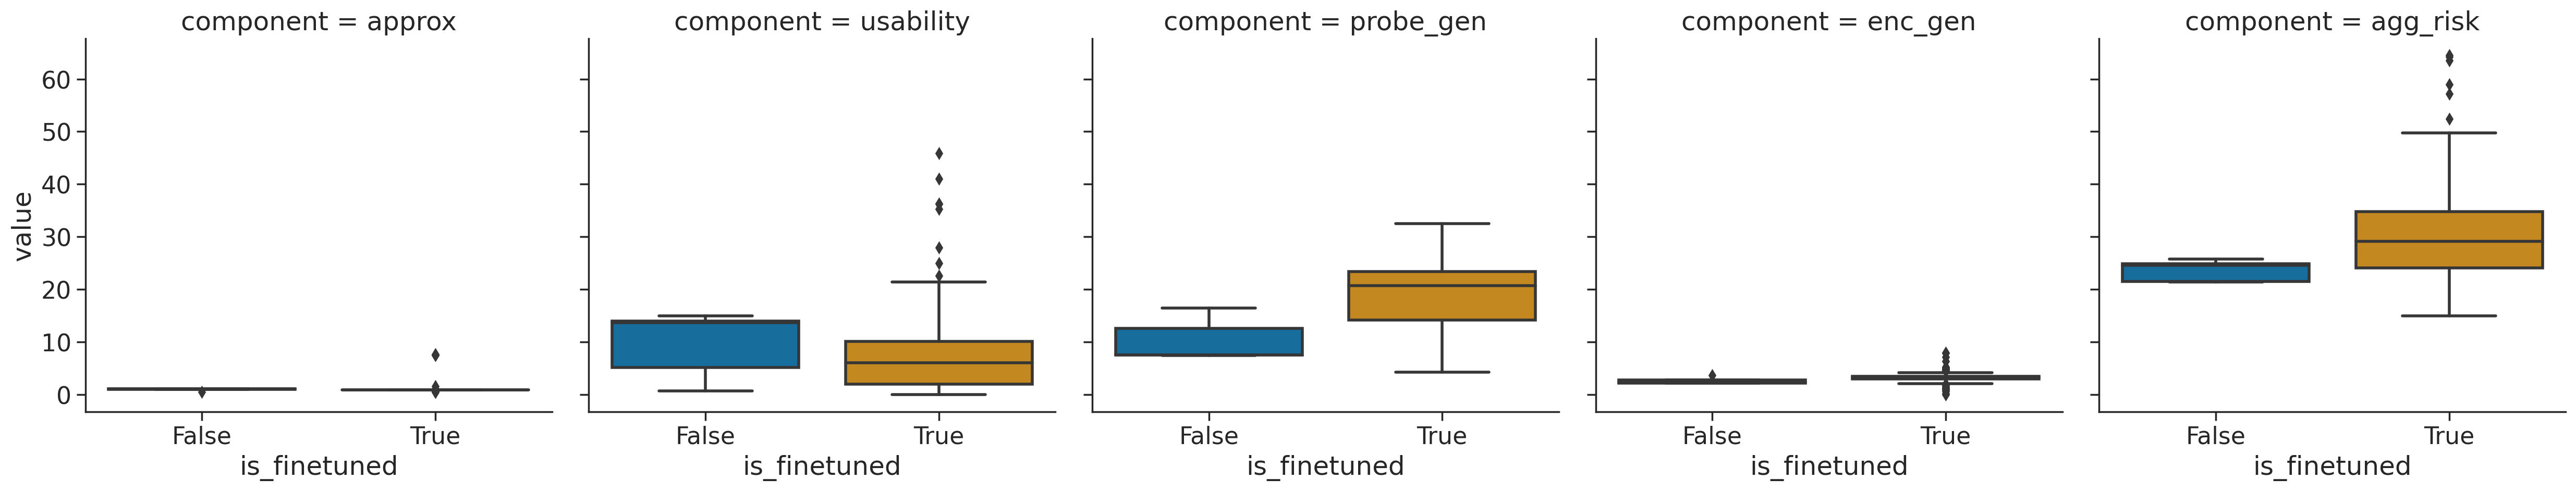

In [35]:
with plot_config():
    g=sns.catplot(data=melt(curr_df), x="is_finetuned", y="value", col="component", facet_kws={'sharey': False}, kind="box")
#g.set(xscale="log")